In [2]:
# !pip3 install -q tensorforce==0.6.4
# !pip install -q tensorflow==2.5.*
# !pip install -q keras==2.5.0rc0
!pip install gym==0.19.0

     |████████████████████████████████| 1.6 MB 43.9 MB/s eta 0:00:01
  Created wheel for gym: filename=gym-0.19.0-py3-none-any.whl size=1663117 sha256=aa2ab55168603069819071600d13d000cab570bc862e8dc4c72af031e906ada8
  Stored in directory: /root/.cache/pip/wheels/11/36/28/628f4dd3779e4037a6fca1aaed76827ffa4315c3ab6bfadcf6
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.18.3
    Uninstalling gym-0.18.3:
      Successfully uninstalled gym-0.18.3


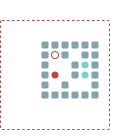

In [8]:
import gym
from pogema.wrappers.multi_time_limit import MultiTimeLimit
from pogema.animation import AnimationMonitor
from IPython.display import SVG, display
import numpy as np
import pogema
from pogema import GridConfig

# Define random configuration
grid_config = GridConfig(num_agents=3, # количество агентов на карте
                         size=4,      # размеры карты
                         density=0.4,  # плотность препятствий
                         seed=1,       # сид генерации задания 
                         max_episode_steps=256,  # максимальная длина эпизода
                         obs_radius=5, # радиус обзора
                        )

env = gym.make("Pogema-v0", grid_config=grid_config)
env = AnimationMonitor(env)

# обновляем окружение
obs = env.reset()

done = [False, ...]

while not all(done):
    # Используем случайную стратегию
    obs, reward, done, info = env.step([np.random.randint(4) for _ in range(len(obs))])
# сохраняем анимацию и рисуем ее
env.save_animation("render.svg", egocentric_idx=1)
display(SVG('render.svg'))

In [17]:
from tensorforce.environments import Environment
from tensorforce.agents import Agent
from tensorforce.agents import DQNAgent
from tensorforce.execution import Runner

In [19]:
import numpy as np

from tensorforce import Environment, Runner


class MultiactorEnvironment(Environment):
    """
    Example multi-actor environment, illustrating best-practice implementation pattern.
    State space: position in [0, 10].
    Action space: movement in {-1, 0, 1}.
    Random start in [3, 7].
    Actor 1 perspective as is, actor 2 perspective mirrored.
    Positive reward for being closer to 10.
    """

    def __init__(self):
        super().__init__()

    def states(self):
        return dict(type='int', num_values=11)

    def actions(self):
        return dict(type='int', num_values=3)

    def num_actors(self):
        return 2  # Indicates that environment has multiple actors

    def reset(self):
        # Always for multi-actor environments: initialize parallel indices
        self._parallel_indices = np.arange(self.num_actors())

        # Single shared environment logic, plus per-actor perspective
        self._states = 3 + np.random.randint(5)
        self.second_actor = True
        states = np.stack([self._states, 10 - self._states], axis=0)

        # Always for multi-actor environments: return per-actor values
        return self._parallel_indices.copy(), states

    def execute(self, actions):
        # Single shared environment logic, plus per-actor perspective
        if self.second_actor:
            self.second_actor = self.second_actor and not (np.random.random_sample() < 0.1)
            terminal = np.stack([False, not self.second_actor], axis=0)
            delta = (actions[0] - 1) - (actions[1] - 1)
            self._states = np.clip(self._states + delta, a_min=0, a_max=10)
            states = np.stack([self._states, 10 - self._states], axis=0)
        else:
            terminal = np.stack([False], axis=0)
            delta = (actions[0] - 1)
            self._states = np.clip(self._states + delta, a_min=0, a_max=10)
            states = np.stack([self._states], axis=0)
        reward = (states - 5.0) / 5.0

        # Always for multi-actor environments: update parallel indices, and return per-actor values
        self._parallel_indices = self._parallel_indices[~terminal]
        return self._parallel_indices.copy(), states, terminal, reward



# Возможно переписать свой класс мультиивент




In [20]:
environment = MultiactorEnvironment.create(
    environment='gym', level=env, max_episode_timesteps=500
)

agent = Agent.create(
    agent='tensorforce', environment=environment, update=64,
    optimizer=dict(optimizer='adam', learning_rate=1e-3),
    objective='policy_gradient', reward_estimation=dict(horizon=20)
)

In [23]:
def main():
    # Multi-actor runner, automatically if environment.num_actors() > 1
    runner = Runner(
        agent=agent,
        environment=environment,
        max_episode_timesteps=500
    )
    runner.run(num_episodes=1000)


if __name__ == '__main__':
    main()

Episodes:   0%|          | 0/1000 [00:00, return=0.00, ts/ep=0, sec/ep=0.00, ms/ts=0.0, agent=0.0%]

1 {'type': 'float', 'shape': (3, 11, 11), 'min_value': 0.0, 'max_value': 1.0}
2 TensorSpec(type=float, shape=(3, 11, 11), min_value=0.0, max_value=1.0)
TensorSpec(type=float, shape=(3, 11, 11), min_value=0.0, max_value=1.0)


TensorforceError: Environment.reset: invalid shape (3, 3, 11, 11) != (3, 11, 11) for  state.

In [4]:

# kwargs = {
#     "l2_regularization" :0.0,
# }

agent = Agent.create(
    agent='ppo', environment=environment, batch_size=10, learning_rate=1e-3, #**kwargs
)

In [21]:
runner = Runner(
    agent=agent,
    environment=environment,
    max_episode_timesteps=500,
    # num_parallel=5, 
    # remote='multiprocessing'
)

# runner.run(num_episodes=200)

runner.run(num_episodes=100, evaluation=True)

runner.close()

Episodes:   0%|          | 0/100 [00:00, return=0.00, ts/ep=0, sec/ep=0.00, ms/ts=0.0, agent=0.0%]

1 {'type': 'float', 'shape': (3, 11, 11), 'min_value': 0.0, 'max_value': 1.0}
2 TensorSpec(type=float, shape=(3, 11, 11), min_value=0.0, max_value=1.0)
TensorSpec(type=float, shape=(3, 11, 11), min_value=0.0, max_value=1.0)


TensorforceError: Environment.reset: invalid shape (3, 3, 11, 11) != (3, 11, 11) for  state.

In [7]:

# Train for 100 episodes
for _ in range(100):
    states = environment.reset()
    terminal = False
    while not terminal:
        actions = agent.act(states=states)
        states, terminal, reward = environment.execute(actions=actions)
        agent.observe(terminal=terminal, reward=reward)

1 {'type': 'float', 'shape': (3, 11, 11), 'min_value': 0.0, 'max_value': 1.0}
2 TensorSpec(type=float, shape=(3, 11, 11), min_value=0.0, max_value=1.0)
TensorSpec(type=float, shape=(3, 11, 11), min_value=0.0, max_value=1.0)


TensorforceError: Environment.reset: invalid shape (1, 3, 11, 11) != (3, 11, 11) for  state.

In [ ]:
# Эта либа позволяет работать только с одним агентом в среде!!! 



# https://github.com/tensorforce/tensorforce/issues/371 возможно решение